# Unsupervised Learning Project: 2023 Global Development and Prosperity Indices
## Anthony R. Poggioli

## Introduction

This project was completed as the final project for the course [Unsupervised Machine Learning](https://www.coursera.org/learn/ibm-unsupervised-machine-learning), part of the [IBM Machine Learning Professional Certificate](https://www.coursera.org/professional-certificates/ibm-machine-learning).

### The Data

This project will focus primarily on unsupervised techniques for clustering, as well as some dimensionality reduction for visualization. For this project, I have selected the [2023 Global Country Development & Prosperity Index data set](https://www.kaggle.com/datasets/tarktunataalt/2023-global-country-development-and-prosperity-index/data) available on Kaggle. This data was taken from the [2023 Legatum Prosperity Index](https://www.prosperity.com/rankings). It contains the following fourteen features:

* `Country` **[str]**: The name of the country.
* `AveragScore` **[float]**: The overall average score of the country across all indicators.
* `SafetySecurity` **[float]**: Freedom from conflict, terrorism, and crime.
* `PersonelFreedom` **[float]**: Rights to speech, assembly, and individual autonomy.
* `Governance` **[float]**: Quality of democracy, rule of law, and government effectiveness.
* `SocialCapital` **[float]**: Strength of personal relationships and civic engagement.
* `InvestmentEnvironment` **[float]**: Conditions for private investment and credict access.
* `EnterpriseConditions` **[float]**: Business environment and market competition.
* `MarketAccessInfrastructure` **[float]**: Ease of trade and quality of infrastructure.
* `EconomicQuality` **[float]**: Macroeconomic stability and employment quality.
* `LivingConditions` **[float]**: Standard of living and access to basic services.
* `Health` **[float]**: Population health and healthcare access.
* `Education` **[float]**: Quality and accessibility of education.
* `NaturalEnvironment` **[float]**: Environmental quality and sustainability.

***Each of the numerical scores is normalized to fall between 0 and 100.***

### Project Objectives

The goal of this project is to determine if the data on individual by-country prosperity and development rankings contain "natural" clusters. That is, I aim to answer: *Can countries be naturally grouped into distinct developmental clusters based on the continuous data considered here? And, if so, do these clusters correlate with geographic region?*

### Personal Goals

My primary goal in this project is to demonstrate a facility with a variety of unsupervised clustering algorithms, namely:

* K-means
* Hierarchical agglomerative clustering
* DBSCAN

Each of these algorithms presents certain advantages and disadvantages in terms of both implementation and interpretation, which I will discuss as I apply each algorithm.

I will also explore dimensionality reduction, focusing on the applications of principal component analysis (PCA) for data visualization.

Further discussion of these algorithms and others can be found in my [notes on unsupervised techniques for clustering and dimensionality reduction](https://github.com/arpogg24/arpogg24.github.io/blob/main/portfolio/notes/unsupervised_methods.pdf).

## Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [2]:
data = pd.read_csv("country_development_prosperity_2023.csv")
data["Country"] = data["Country"].str.split().str.join(" ")

Let's get some preliminary information about our data:

In [3]:
print(data.columns.tolist())
print('\n')
print(data.dtypes)
print('\n')
print("number of columns = " + str(data.shape[0]))
print('\n')
print("number of unique countries = " + str(data["Country"].unique().shape[0]))
print('\n')
print(data.describe())
print('\n')
print("number of duplicated rows = " + str(data.duplicated().sum()))

['Country', 'AveragScore', 'SafetySecurity', 'PersonelFreedom', 'Governance', 'SocialCapital', 'InvestmentEnvironment', 'EnterpriseConditions', 'MarketAccessInfrastructure', 'EconomicQuality', 'LivingConditions', 'Health', 'Education', 'NaturalEnvironment']


Country                        object
AveragScore                   float64
SafetySecurity                float64
PersonelFreedom               float64
Governance                    float64
SocialCapital                 float64
InvestmentEnvironment         float64
EnterpriseConditions          float64
MarketAccessInfrastructure    float64
EconomicQuality               float64
LivingConditions              float64
Health                        float64
Education                     float64
NaturalEnvironment            float64
dtype: object


number of columns = 167


number of unique countries = 167


       AveragScore  SafetySecurity  PersonelFreedom  Governance  \
count   167.000000      167.000000       167.000000  167.000000 

From the above, we see that

1. The field names and data types match what we expect from the Kaggle data card,
2. No countries are duplicated,
3. There are no null values (indicated by the fact that count = 167 for all features), and
4. All of the numerical indices fall between 0 and 100, as anticipated.

Next, let's check to see if the data is ordered by `AveragScore`. Specifically, is `AveragScore` strictly decreasing, non-increasing, or unordered?

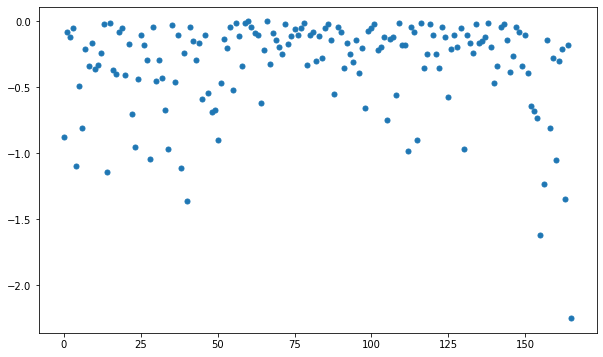

The average scores are non-increasing.
The pairs of countries with identical average scores are:
	Armenia and Bahrain, score = 60.92
	Oman and Dominican Republic, score = 59.85


In [4]:
diff_vec = np.diff(data["AveragScore"].to_numpy())

fig, ax = plt.subplots(1, figsize = (10,6))
plt.plot(diff_vec, '.' , ms = 10)
plt.show()

if np.max(diff_vec) < 0: print("The average scores are strictly decreasing.")
if np.max(diff_vec) == 0: print("The average scores are non-increasing.")
nochange = np.where(diff_vec == 0)[0]
print("The pairs of countries with identical average scores are:")
for index in nochange:
    strprint = "\t" + str(data["Country"].iloc[index]) + " and " + str(data["Country"].iloc[index + 1]) + \
                ", score = " + str(data["AveragScore"].iloc[index])
    print(strprint)

We see that `AveragScore` is non-increasing, with two duplicated scores. We can therefore take the order of the data in the dataframe as the rank of the country.

Next, let's check for any outliers, using the typical outlier box plot criterion. That is, a data point is considered an outlier if it is either greater than the third quartile plus 1.5-times the interquartile range (IQR) or less than the first quartile minus 1.5-times the IQR.

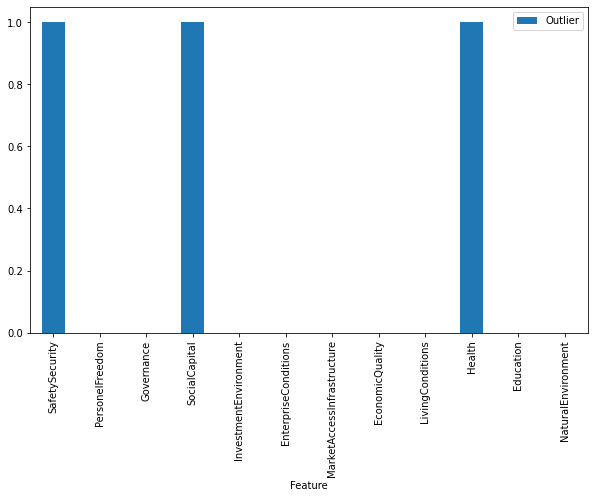

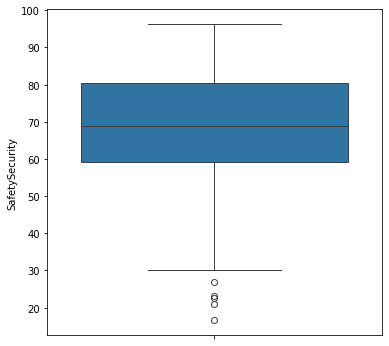

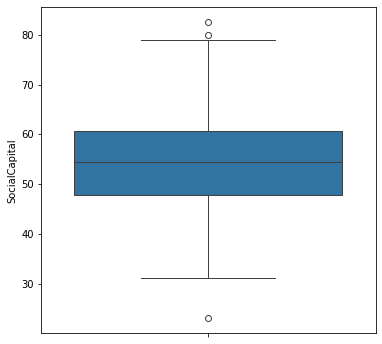

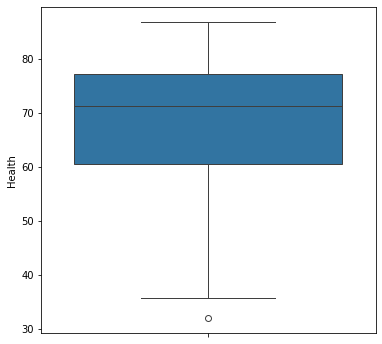

In [5]:
numerical_features = [x for x in data.columns if (x != "Country") and (x != "AveragScore")]
outlier_present = []

for feature in numerical_features:
    p25 = data[feature].quantile(0.25)
    p75 = data[feature].quantile(0.75)
    iqr = p75 - p25
    upper_bound = p75 + 1.5*iqr
    lower_bound = p25 - 1.5*iqr
    #if (np.max(data[feature]) > upper_bound) or (np.min(data[feature
    if (data[feature].max() > upper_bound) or (data[feature].min() < lower_bound):
        outlier_present.append(1)
    else: outlier_present.append(0)

outlier_features = [numerical_features[i] for i in range(0,len(numerical_features)) if outlier_present[i] == 1]
    
outlier_df = pd.DataFrame({"Feature": numerical_features, "Outlier": outlier_present})
fig, ax = plt.subplots(1, figsize = (10,6))
outlier_df.plot(x = "Feature", y = "Outlier", kind = "bar", ax = ax)
plt.show()

for feature in outlier_features:
    fig, ax = plt.subplots(1, figsize = (6,6))
    sns.boxplot(data = data[feature])
    plt.show()

We see that three features, `SafetySecurity`, `SocialCapital`, and `Health` contain outliers. Comparing this against [the original data source](https://www.prosperity.com/rankings), we see that they have been correctly transcribed, and we will assume that they are accurate.

Now, let's check to see if any of our features are highly correlated:

['Governance', 'InvestmentEnvironment']


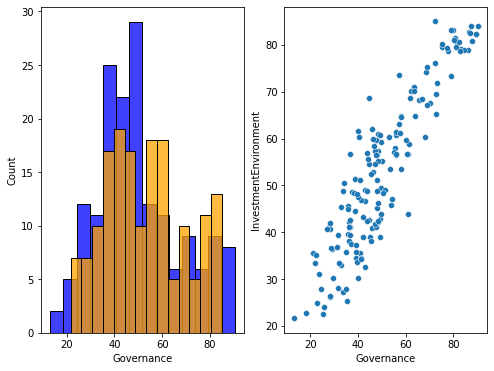

['Governance', 'EnterpriseConditions']


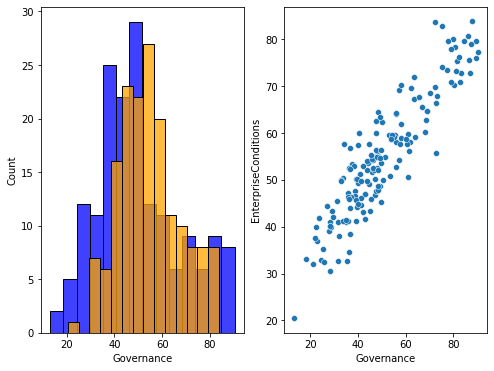

['InvestmentEnvironment', 'EnterpriseConditions']


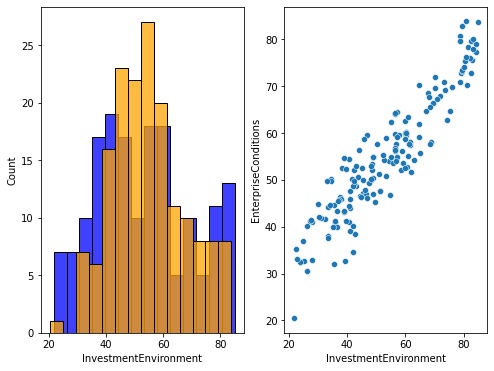

['InvestmentEnvironment', 'MarketAccessInfrastructure']


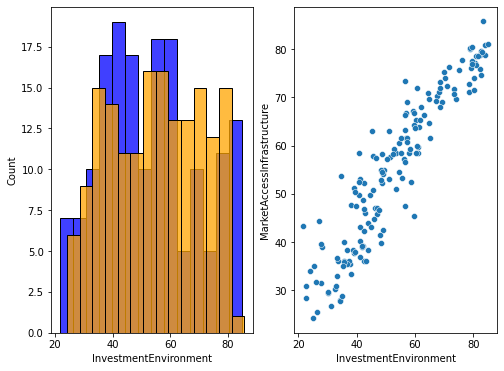

['MarketAccessInfrastructure', 'LivingConditions']


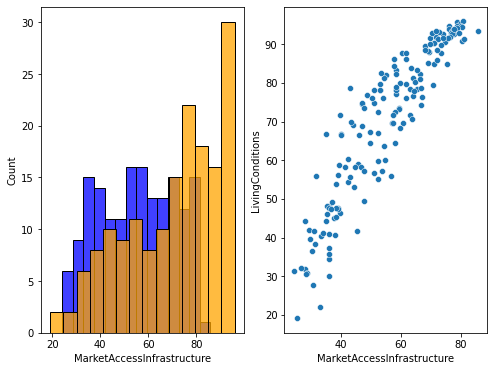

['MarketAccessInfrastructure', 'Education']


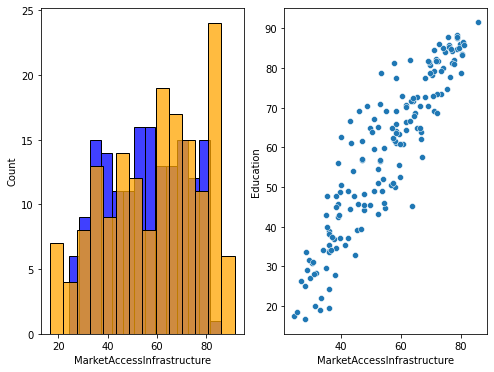

['LivingConditions', 'Health']


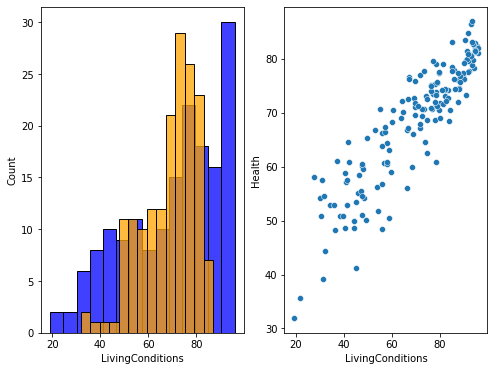

['LivingConditions', 'Education']


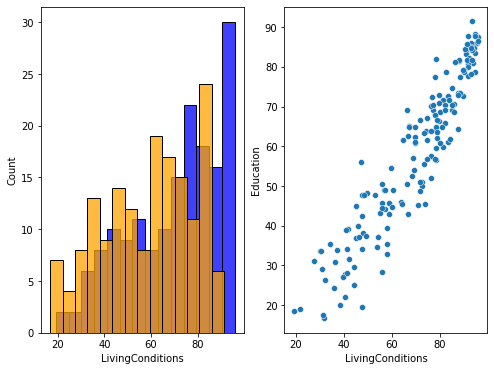

In [6]:
corr_mat = data[numerical_features].corr().to_numpy()
for x in range(corr_mat.shape[0]):
    corr_mat[x,x] = 0
correlated_pairs = []
for i in range(0,len(numerical_features)):
    for j in range(i,len(numerical_features)):
        if np.abs(corr_mat[i,j]) > 0.9:
            correlated_pairs.append([numerical_features[i], numerical_features[j]])
Nbins = 14
for features in correlated_pairs:
    print(features)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (8,6))
    sns.histplot(data = data, x = features[0], ax = ax1, bins = Nbins, color = "blue")
    sns.histplot(data = data, x = features[1], ax = ax1, bins = Nbins, color = "orange")
    sns.scatterplot(data = data, x = features[0], y = features[1], ax = ax2)
    plt.show()

We see that eight feature pairs have absolute Pearson correlation coefficients greater than 0.9. Furthermore, from the scatter plots above, we see that most of these pairs do indeed exhibit a high degree of positive linear correlation. That is, they exhibit a high degree of *multicolinearity*. However, comparing the histograms of the variable pairs, we see that some of the variables have notably different empirical distributions -- for example `MarketAccessInfrastructure` and `LivingConditions` or `LivingConditions` and `Health` -- suggesting that these variables present very different distributions and/or are nonlinearly related.

Multicolinearity can be a debilitating issue for predictive (supervised) machine learning algorithms like multiple linear regression. If we were applying such a supervised technique to this data, we would likely first have to perform dimensionality reduction using, e.g., PCA. Multicolinearity is not anticipated to affect the results of our clustering analyses, but it will likely affect the interpretability of our results. This is because, if many pairs of features are highly correlated, it is difficult or impossible to ascribe a fundamentally causal role to any one variable.

We could use this high degree of correlation to perform feature selection, eliminating features that are largely redundant. However, I will not do so for three reasons. First of all, retaining all features will potentially aid in interpretation. Secondly, the data set is quite small, and feature elimination will not improve computational performance. Third, the number of observations ($N = 167$) exceeds the number of features ($p = 12$) by a factor of nearly $14$, indicating that the so-called *curse of dimensionality* will likely not be an issue.

### Data Scaling

We now scale our data. We chose a standard scaling, in which each feature is centered and normalized by its standard deviation. Centering will be advantageous in interpreting the components produced by the PCA analysis because we will not have to shift the vector returned by `PCA.components_` by the mean of the data cloud to determine the principal components in feature space.

In [7]:
scaled_data = StandardScaler().fit_transform(data[numerical_features])
df_dict = {"Country": data["Country"].tolist()}
for i in range(0,len(numerical_features)):
    df_dict[numerical_features[i]] = scaled_data[:,i]
df_dict["AveragScore"] = scaled_data.mean(axis = 1)
scaled_data = pd.DataFrame(df_dict)

# check scaling:
for feature in numerical_features:
    strprint = feature + ": mean = " + str(scaled_data[feature].mean()) \
                       + ", std = " + str(scaled_data[feature].std())
    print(strprint)

SafetySecurity: mean = -3.8292722286472466e-16, std = 1.003007525587691
PersonelFreedom: mean = 1.7018987682876652e-16, std = 1.0030075255876907
Governance: mean = -1.2764240762157488e-16, std = 1.003007525587691
SocialCapital: mean = 3.8292722286472466e-16, std = 1.003007525587691
InvestmentEnvironment: mean = -2.5528481524314976e-16, std = 1.003007525587691
EnterpriseConditions: mean = -3.8292722286472466e-16, std = 1.0030075255876907
MarketAccessInfrastructure: mean = 3.4037975365753304e-16, std = 1.003007525587691
EconomicQuality: mean = -2.5528481524314976e-16, std = 1.003007525587691
LivingConditions: mean = 9.360443225582159e-16, std = 1.003007525587691
Health: mean = 2.169920929566773e-15, std = 1.003007525587691
Education: mean = 0.0, std = 1.003007525587691
NaturalEnvironment: mean = -8.084019149366409e-16, std = 1.003007525587691


We check our scaled data and confirm that, to within an acceptable accuracy, it now has zero mean and unit standard deviation.

### Initial Visualization Using PCA

Finally, before moving on to our clustering analysis, let's take a look at the data in principal component space to see if we can identify any obvious clustering visually.

[0.74463601]


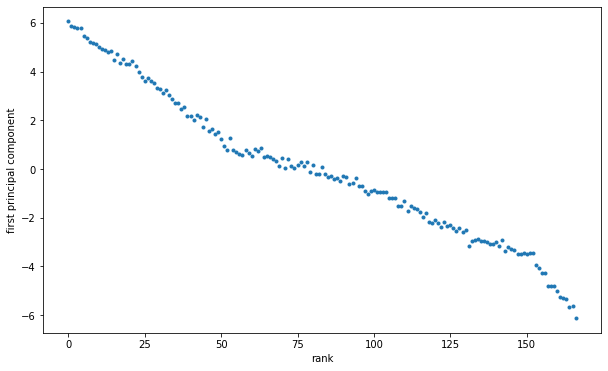

[0.74463601 0.08922787]
0.8338638883870132


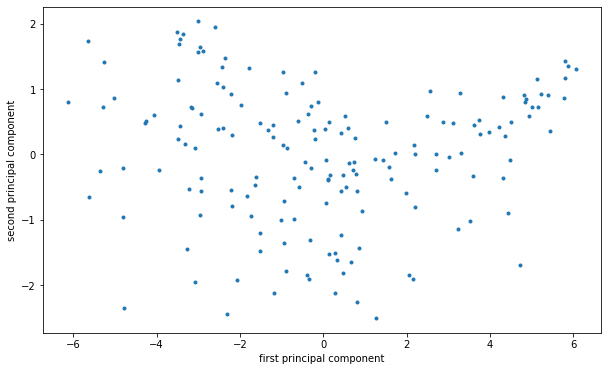

[0.74463601 0.08922787 0.04497363]
0.8788375140172633


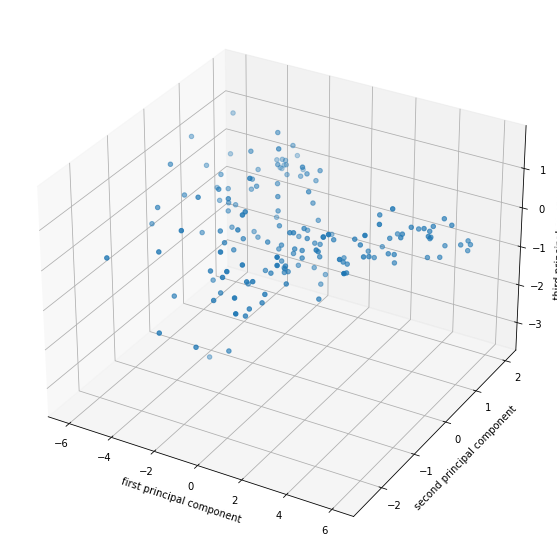

In [8]:
pca1 = PCA(n_components = 1).fit(scaled_data[numerical_features])
print(pca1.explained_variance_ratio_)
pca1_trans = pca1.transform(scaled_data[numerical_features])
fig, ax = plt.subplots(1, figsize = (10,6))
plt.plot(pca1_trans, '.')
plt.xlabel("rank")
plt.ylabel("first principal component")
plt.show()

pca2 = PCA(n_components = 2).fit(scaled_data[numerical_features])
print(pca2.explained_variance_ratio_)
print(np.sum(pca2.explained_variance_ratio_))
pca2_trans = pca2.transform(scaled_data[numerical_features])
fig, ax = plt.subplots(1, figsize = (10,6))
plt.plot(pca2_trans[:,0], pca2_trans[:,1], '.')
plt.xlabel("first principal component")
plt.ylabel("second principal component")
plt.show()

pca3 = PCA(n_components = 3).fit(scaled_data[numerical_features])
print(pca3.explained_variance_ratio_)
print(np.sum(pca3.explained_variance_ratio_))
pca3_trans = pca3.transform(scaled_data[numerical_features])
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection = "3d")
ax.scatter(pca3_trans[:,0], pca3_trans[:,1], pca3_trans[:,2])
ax.set_xlabel("first principal component")
ax.set_ylabel("second principal component")
ax.set_zlabel("third principal component")
plt.show()

Interestingly, the first principal component explains over 74% of the total variance, with the second principal component explaining an additional 8.9% and the third only 4.5%. The first two principal components show only weak evidence of clustering, with two or possibly three, clusters visually identifiable. The first three principal components possibly show more evidence of clustering, though it is still appears to be relatively weak. Including additional principal components is unlikely to lead to more pronounced coupling because they contribute little to the total variance.

## K-Means Clustering

We begin our analysis with k-means clustering. The key limitations of this method are that it requires us to specify the number of clusters manually and that it assumes roughly spherical and identically sized clusters. We first address the latter point by using the so-called elbow method, in which we plot the inertia as a function of the number of clusters and choose the appropriate number by identifying the slope break in the resultant plot:

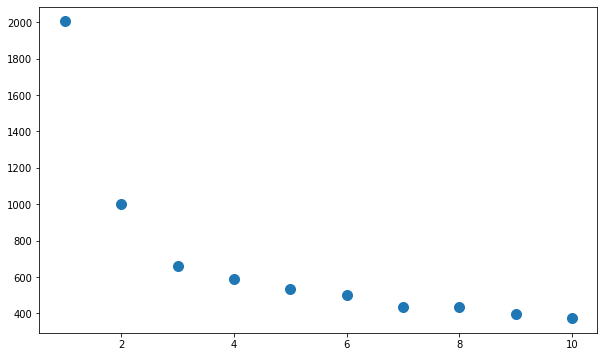

In [9]:
klist = [x for x in range(1,11)]
inertia = []

for k in klist:
    km = KMeans(n_clusters = k).fit(scaled_data[numerical_features])
    inertia.append(km.inertia_)

fig, ax = plt.subplots(1,figsize = (10,6))
plt.plot(klist, inertia, '.', ms = 20)
plt.show()

While the slope break is not as pronounced as we might hope, we can identify $k = 3$ as an "optimal" number of clusters. We will proceed with three clusters.

Let's finalize our model and look at what this clustering looks like in principal component space:

In [10]:
km = KMeans(n_clusters = 3).fit(scaled_data[numerical_features])

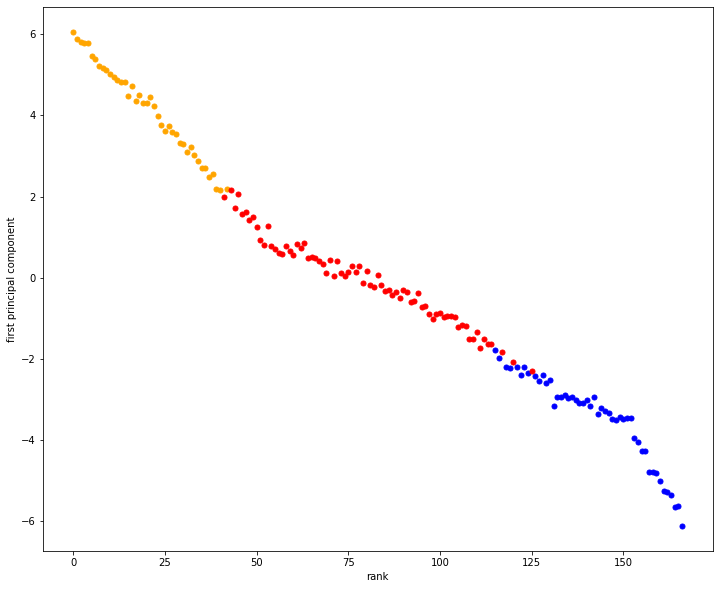

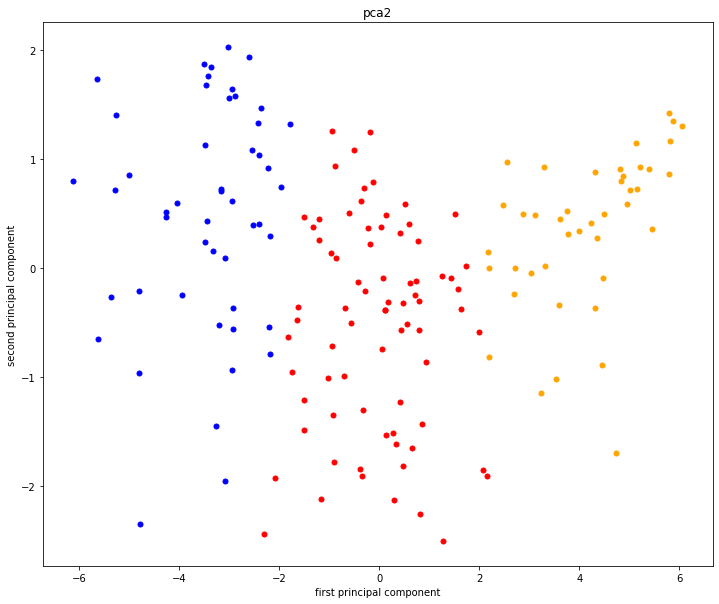

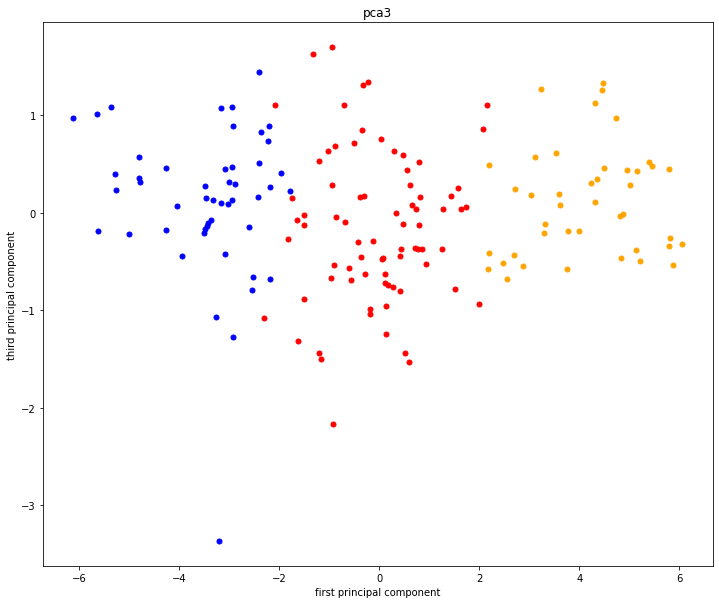

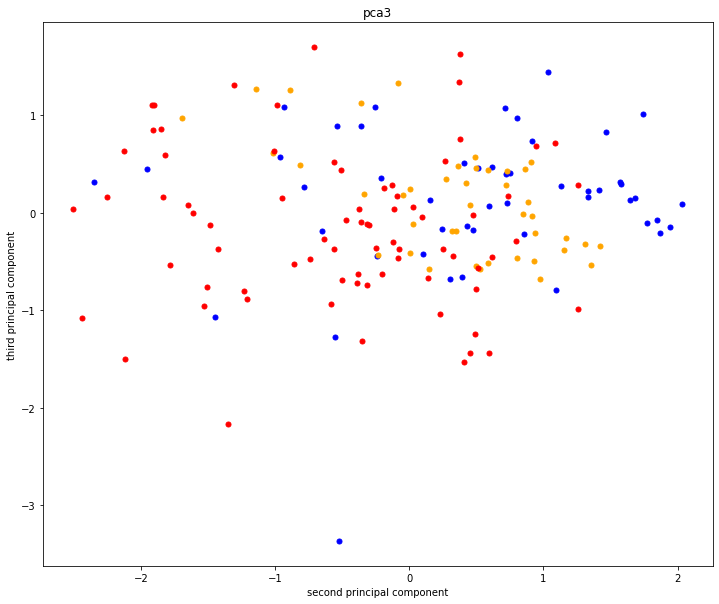

In [11]:
country_rank = np.arange(0,len(pca1_trans))

fig, ax = plt.subplots(1, figsize = (12,10))
plt.plot(country_rank[km.labels_ == 0], pca1_trans[km.labels_ == 0], '.', color = "blue", ms = 10)
plt.plot(country_rank[km.labels_ == 1], pca1_trans[km.labels_ == 1], '.', color = "orange", ms = 10)
plt.plot(country_rank[km.labels_ == 2], pca1_trans[km.labels_ == 2], '.', color = "red", ms = 10)
plt.xlabel("rank")
plt.ylabel("first principal component")

fig, ax = plt.subplots(1, figsize = (12,10))
plt.plot(pca2_trans[km.labels_ == 0, 0], pca2_trans[km.labels_ == 0, 1], '.', color = "blue", ms = 10)
plt.plot(pca2_trans[km.labels_ == 1, 0], pca2_trans[km.labels_ == 1, 1], '.', color = "orange", ms = 10)
plt.plot(pca2_trans[km.labels_ == 2, 0], pca2_trans[km.labels_ == 2, 1], '.', color = "red", ms = 10)
plt.title("pca2")
plt.xlabel("first principal component")
plt.ylabel("second principal component")
plt.show()

fig, ax = plt.subplots(1, figsize = (12,10))
plt.plot(pca3_trans[km.labels_ == 0, 0], pca3_trans[km.labels_ == 0, 2], '.', color = "blue", ms = 10)
plt.plot(pca3_trans[km.labels_ == 1, 0], pca3_trans[km.labels_ == 1, 2], '.', color = "orange", ms = 10)
plt.plot(pca3_trans[km.labels_ == 2, 0], pca3_trans[km.labels_ == 2, 2], '.', color = "red", ms = 10)
plt.title("pca3")
plt.xlabel("first principal component")
plt.ylabel("third principal component")
plt.show()

fig, ax = plt.subplots(1, figsize = (12,10))
plt.plot(pca3_trans[km.labels_ == 0, 1], pca3_trans[km.labels_ == 0, 2], '.', color = "blue", ms = 10)
plt.plot(pca3_trans[km.labels_ == 1, 1], pca3_trans[km.labels_ == 1, 2], '.', color = "orange", ms = 10)
plt.plot(pca3_trans[km.labels_ == 2, 1], pca3_trans[km.labels_ == 2, 2], '.', color = "red", ms = 10)
plt.title("pca3")
plt.xlabel("second principal component")
plt.ylabel("third principal component")
plt.show()

We see from the the scatter plot of the first and second principal components that k-means does indeed identify three roughly equally sized clusters. Interestingly, this plot indicates that the data is primarily segregated by the first principal component alone. This is confirmed by the plot of the first principal component versus rank, which indicates that the clustering criterion can be formulated as thresholds in the first principal component, notwithstanding some overlap between the intermediate and low-rank clusters.

The scatter plot of the second and third rank principal components indicates almost no distinction between the clusters, indicating that the inclusion of the third principal component contributes little to distinguishing clusters. Altogether, these plots suggest that our data is very nearly effectively one-dimensional.

Let's look at the components of the first principal components to get a sense of the contributions from each individual feature. We will normalize our plot such that a value of unity for the normalized contribution will indicate that the coefficient is $1/p = 1/12$. That is, if each normalized coefficient is unity, this indicates that every feature contributes equally to the first principal component.

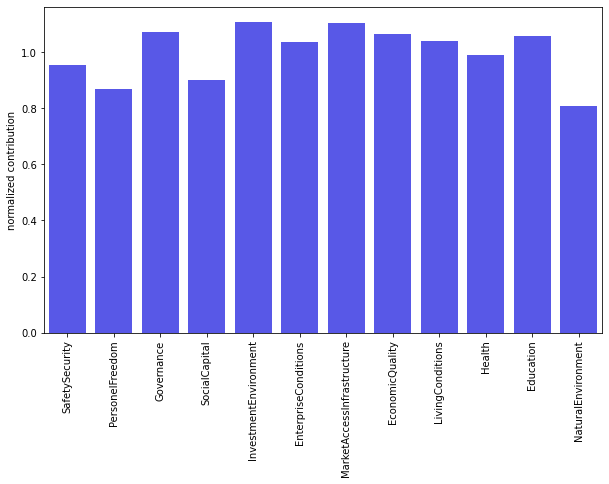

In [12]:
pca1_coefficients = pca1.components_

fig, ax = plt.subplots(1, figsize = (10,6))
sns.barplot(x = numerical_features, y = 12*pca1_coefficients[0]/np.sum(pca1_coefficients[0]), ax = ax, color = "blue", alpha = 0.75)
plt.xticks(rotation = 90)
plt.ylabel("normalized contribution")
plt.show()

This plot shows that all of the features contribute nearly equally. This is further evidence that each of the features in our data set really measures a single underlying feature -- or equivalently that they are all highly correlated -- and our data is therefore quasi-one-dimensional.

Next, let's look at how each feature and the average score correlate with the first principal component. This may at first seem trivial; the feature with the largest coefficient in the first principal component (`InvestmentEnvironment`) should presumably be the most strongly correlated with this component. However, this neglects the fact that there are high degrees of correlation between several different pairs of variables, which will also play a role in determining which variable is most highly correlated with the first principal component. Mathematically, if we express the unit vector in the direction of the first principal component $\hat{\mathbf{P}}_1$ in terms of the unit vectors in *centered* feature space corresponding to our original features, $\left\{ \hat{\mathbf{x}} \right\}_i^p$, as

$$
\hat{\mathbf{P}}_1 = \sum_{i = 1}^p c_i \hat{\mathbf{x}}_i,
$$

with $\sum_i c_i^2 = 1$, then the projection of a particular observation $\mathbf{x}^{\alpha}$, $\alpha \in \left\{1, 2, ..., N \right\}$, on $\hat{\mathbf{P}}_1$ is

$$
\mathbf{x}^{\alpha} \cdot \hat{\mathbf{P}}_1 = \sum_{i = 1}^p c_i x_i^{\alpha},
$$

where $x_i^{\alpha}$ is the $i$-th feature associated with the $\alpha$-th observation. The Pearson correlation of feature $x_j$ with the first principal component is therefore given by

$$
\frac{\sum_{\alpha = 1}^N x_j^{\alpha} \sum_{i = 1}^p c_i x_i^{\alpha}}{\sqrt{\sum_{\alpha = 1}^N \left( x_j^{\alpha} \right)^2 \sum_{\beta = 1}^N \left( \sum_{i = 1}^p c_i x_i^{\beta} \right)^2}} \propto \sum_{i = 1}^p c_i \sum_{\alpha = 1}^N x_j^{\alpha} x_i^{\alpha},
$$

from which we see that the strength of the correlation of a particular feature with the first principal component is determined not just by the expansion coefficient $c_i$ but also by the strength of the correlation of that feature with every other feature. This leaves open the possiblity that one or a few features will be more significantly correlated with the first principal component that the others.

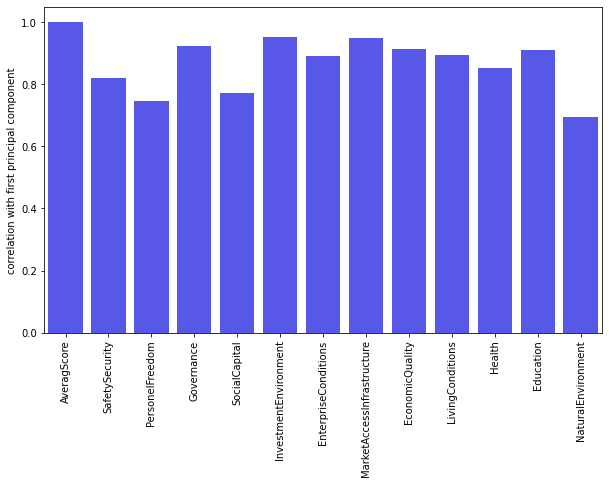

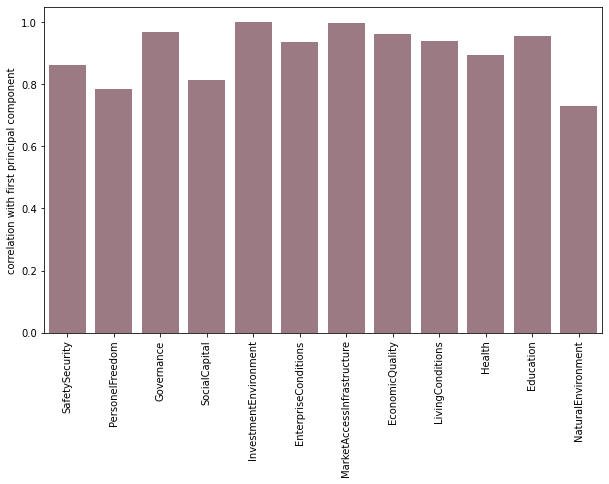

The most highly correlated feature (other than the average score) is InvestmentEnvironment, with a correlation coefficient = 0.9515685436930028.


In [13]:
feature_list = ["AveragScore"] + numerical_features

feature_pca1_corr = []
for feature in feature_list:
    feature_pca1_corr.append(np.corrcoef(scaled_data[feature], pca1_trans[:,0])[0,1])

fig, ax = plt.subplots(1, figsize = (10,6))
sns.barplot(x = feature_list, y = feature_pca1_corr, ax = ax, color = "blue", alpha = 0.75)
plt.xticks(rotation = 90)
plt.ylabel("correlation with first principal component")
plt.show()

fig, ax = plt.subplots(1, figsize = (10,6))
sns.barplot(x = feature_list[1:], y = feature_pca1_corr[1:]/max(feature_pca1_corr[1:]), ax = ax, color = "blue", alpha = 0.75)
sns.barplot(x = feature_list[1:], y = pca1_coefficients[0]/np.max(pca1_coefficients[0]), ax = ax, color = "orange", alpha = 0.5)
plt.xticks(rotation = 90)
plt.ylabel("correlation with first principal component")
plt.show()

# I know this is an absurd way to return the second largest value; I am being lazy
max_not_average = np.max(feature_pca1_corr[1:])
max_feature = [feature_list[i] for i in range(0,len(feature_list))
               if (feature[i] != "AveragScore") and feature_pca1_corr[i] == max_not_average]

strprint = "The most highly correlated feature (other than the average score) is " + max_feature[0] + \
           ", with a correlation coefficient = " + str(max_not_average) + "."
print(strprint)

However, we find -- somewhat surprisingly -- that the correlations of the individual features with the first principal component are determined entirely by their coefficients in the expansion, despite the high bivariate correlations observed above. `InvestmentEnvironment` is therefore the feature most correlated with the first principal component, with a Pearson coefficient of 0.95. Given the high degree of multicollinearity observed in this data, it is not possible to ascribe much significance to this observation.

We further observe that `AveragScore` is almost perfectly correlated with the first principal component, consistent with our above observation that each feature contributes roughly equally to the first principal component.

All told, we have learned that our data is quasi-one-dimensional -- at least as inferred from k-means clustering -- and that this dimension is given to a high degree of approximation by the average of all indices.

Let's see how these clusters correlate with geographic region:

In [14]:
print(np.array(colors.to_rgb("blue"))*255)
print(np.array(colors.to_rgb("orange"))*255)
print(np.array(colors.to_rgb("red"))*255)
print(np.array(colors.to_rgb("purple"))*255)
print(np.array(colors.to_rgb("green"))*255)

[  0.   0. 255.]
[255. 165.   0.]
[255.   0.   0.]
[128.   0. 128.]
[  0. 128.   0.]


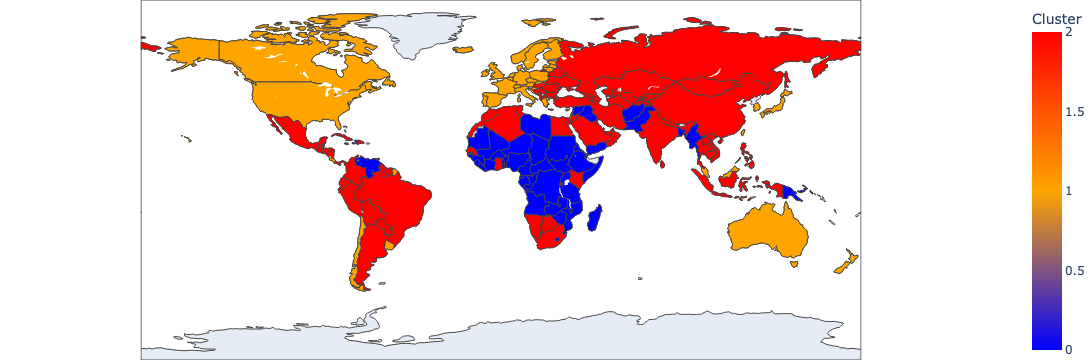

In [15]:
cluster_df = pd.DataFrame({"Country": data["Country"].tolist(),
                           "Cluster": km.labels_})

colorvec = ["rgb(0, 0, 255)", "rgb(255, 165, 0)", "rgb(255, 0, 0)"]

fig = px.choropleth(cluster_df, locationmode = "country names", locations = cluster_df["Country"],
                    scope = "world", color = cluster_df["Cluster"],
                    color_continuous_scale = colorvec,
                    range_color = (0,2))

#fig.update_layout(margin = {"r":0,"t":0,"l":0,"b":0}, width = 500, height = 500)
fig.update_layout(margin = {"r":0,"t":0,"l":0,"b":0})
fig.show()

Indeed, the clusters reproduce a typical picture of the geographic distribution of development. The highest rank countries are for the most part in North America, Western Europe, and Oceania, with the typical additions of Japan, South Korea, and Chile. The intermediate ranked countries are largely in Eastern Europe, Asia, and South and Central America, with the typical additions of some North African countries and South Africa. Finally, the lowest ranked countries are in Africa and parts of Asia and South America.

It is an open question whether this is a corroboration of this typical picture of development, or if this reveals certain economic, cultural, and geographic biases in the data itself.

## Hierarchical Agglomerative Clustering (HAC)

Next, let's take a look at HAC, a fundamentally different clustering approach that successively combines smaller clusters into larger clusters based on an imposed measure of difference. Here, we will use the Ward linkage criterion, which measures the dissimilarity between cluster pairs by the inertia of the combined cluster. Ward linkage is robust to both large clusters and outliers that lie in between clusters.

Two principal advantages of HAC are that it allows for non-convex and unequally sized clusters and that it provides greater interpretability by showing the smaller clusters of which larger clusters are composed. I will refer to the latter property as "fine structure" in what follows.

Let's first look at what a three-cluster HAC model produces:

linkage = ward, clusters = 3


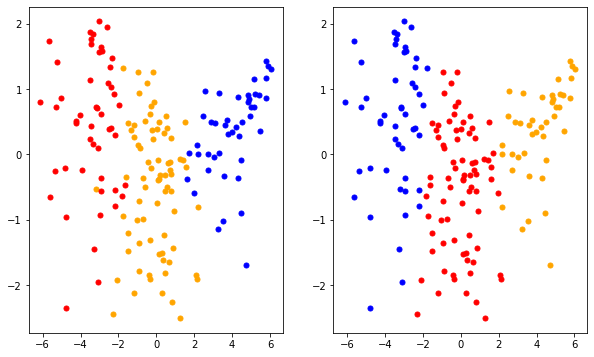

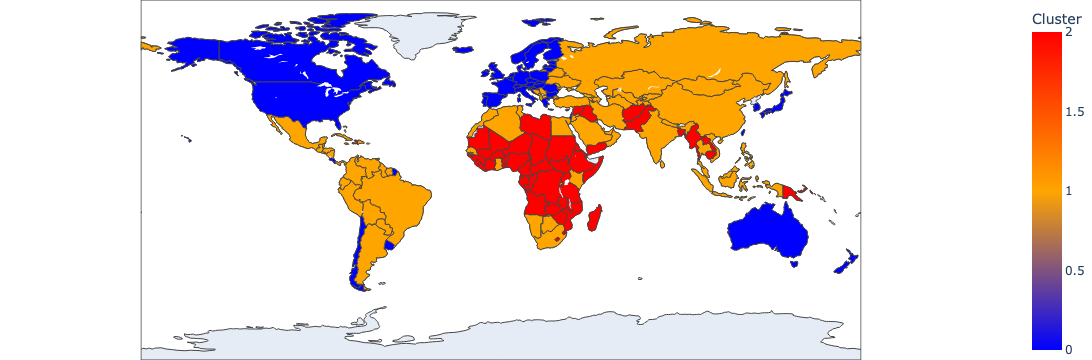

In [16]:
print("linkage = ward, clusters = 3")

HAC = AgglomerativeClustering(n_clusters = 3, metric = "euclidean", linkage = "ward").fit(scaled_data[numerical_features])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6))
ax1.plot(pca2_trans[HAC.labels_ == -1, 0], pca2_trans[HAC.labels_ == -1, 1], '.', color = "black", ms = 10)
ax1.plot(pca2_trans[HAC.labels_ == 0, 0], pca2_trans[HAC.labels_ == 0, 1], '.', color = "blue", ms = 10)
ax1.plot(pca2_trans[HAC.labels_ == 1, 0], pca2_trans[HAC.labels_ == 1, 1], '.', color = "orange", ms = 10)
ax1.plot(pca2_trans[HAC.labels_ == 2, 0], pca2_trans[HAC.labels_ == 2, 1], '.', color = "red", ms = 10)
ax2.plot(pca2_trans[km.labels_ == -1, 0], pca2_trans[km.labels_ == -1, 1], '.', color = "black", ms = 10)
ax2.plot(pca2_trans[km.labels_ == 0, 0], pca2_trans[km.labels_ == 0, 1], '.', color = "blue", ms = 10)
ax2.plot(pca2_trans[km.labels_ == 1, 0], pca2_trans[km.labels_ == 1, 1], '.', color = "orange", ms = 10)
ax2.plot(pca2_trans[km.labels_ == 2, 0], pca2_trans[km.labels_ == 2, 1], '.', color = "red", ms = 10)
plt.show()

cluster_df = pd.DataFrame({"Country": data["Country"].tolist(),
                           "Cluster": HAC.labels_})

colorvec = ["rgb(0, 0, 255)", "rgb(255, 165, 0)", "rgb(255, 0, 0)"]

fig = px.choropleth(cluster_df, locationmode = "country names", locations = cluster_df["Country"],
                    scope = "world", color = cluster_df["Cluster"],
                    color_continuous_scale = colorvec,
                    range_color = (0,2))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Remarkably, our clusters are essentially identical to those identified using k-means. This suggests our previous analysis was indeed robust.

Now, let's take a look at how HAC models with more clusters (five and four) collapse into our three cluster model:

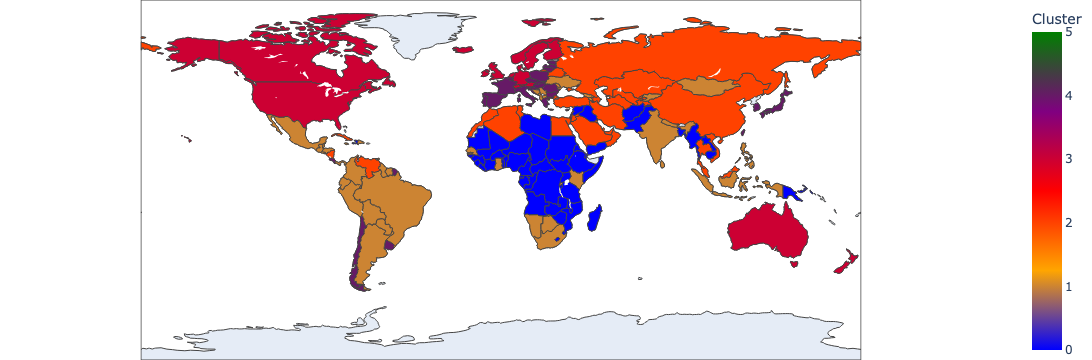

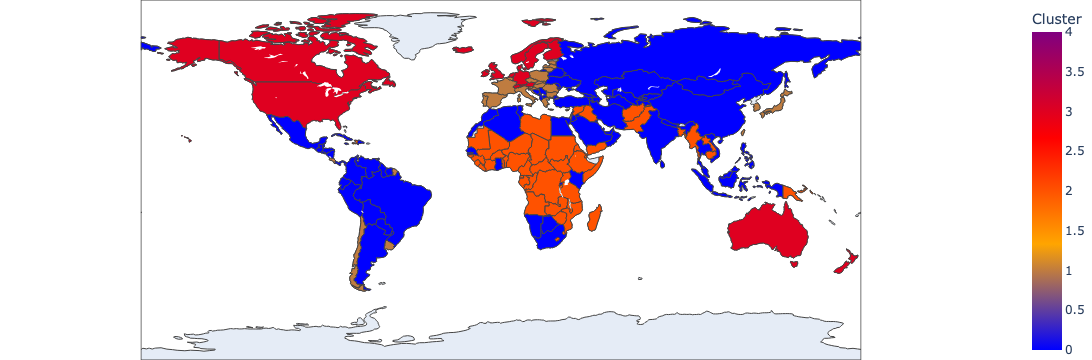

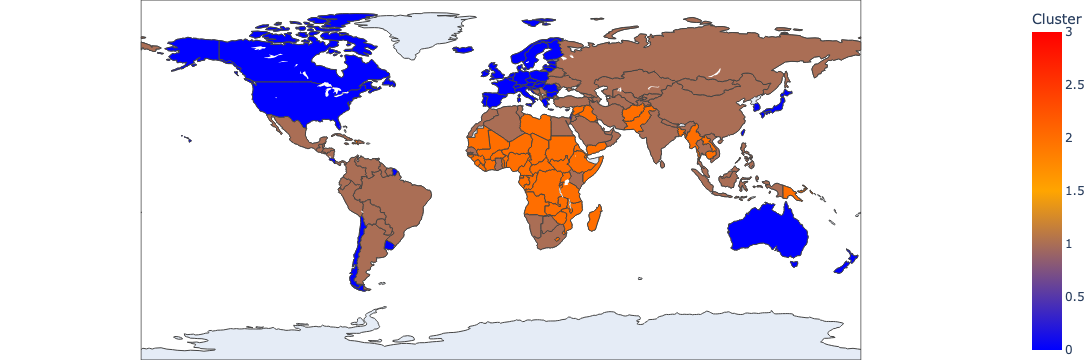

In [17]:
colorvec = ["rgb(0, 0, 255)", "rgb(255, 165, 0)", "rgb(255, 0, 0)",
            "rgb(128, 0, 128)", "rgb(0, 128, 0)"]
for Nclusters in range(5,2,-1):
    HAC = AgglomerativeClustering(n_clusters = Nclusters, metric = "euclidean", linkage = "ward").fit(scaled_data[numerical_features])
    cluster_df = pd.DataFrame({"Country": data["Country"].tolist(),
                           "Cluster": HAC.labels_})
    fig = px.choropleth(cluster_df, locationmode = "country names", locations = cluster_df["Country"],
                        scope = "world", color = cluster_df["Cluster"],
                        color_continuous_scale = colorvec[:Nclusters],
                        range_color = (0,Nclusters))
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

These models illustrate potentially meaningful fine structure. For example, both the five- and four-cluster models illustrate a distinction between Nordic countries on one hand and Western and Eastern European countries on the other. This corroborates common distinctions in development and quality of life between Nordic and other European countries.

This fine structure is interesting and worth further investigation. However, a key takeaway from this analysis will be that HAC, a fundamentally different clustering technique from k-means, recapitulates the results of the latter method, providing evidence for the robustness of the clustering we have identified.

## DBSCAN

Finally, we will look at a third fundamentally different clustering technique, DBSCAN. DBSCAN is distinct both because it is based on the empirical density of points in feature space, attemtpting to identify clusters with points near density peaks. It is also distinct in the fact that it is a *true clustering algorithm* in the sense that it allows for points to be classified as outliers rather than members of a cluster. This is in contrast to methods that return a cluster membership for every point (like k-means and HAC), which are sometimes called *segmentation algorithms*.

The principal advantages of DBSCAN are that 1) we do not have to specify the number of clusters *a priori* and 2) clusters need not be convex or equally sized.

However, this comes at the expense of introducing two new hyperparameters, called `min_samples` and `eps` in `scikit-learn`. ([The technical details behind these parameters are discussed in my more extensive notes on unsupervised learning.](https://github.com/arpogg24/arpogg24.github.io/blob/main/portfolio/notes/unsupervised_methods.pdf))

Let's look at the number of clusters and the *clustering fraction* as a function of `min_samples` and `eps`. The clustering fraction is the fraction points that are placed in clusters, rather than being labeled as outliers. A useful clustering result will produce more than one cluster and have a reasonably high clustering fraction. 

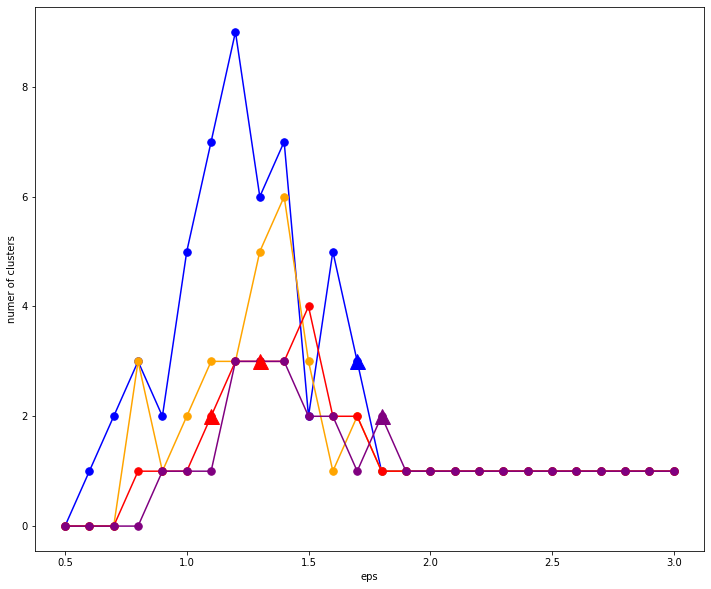

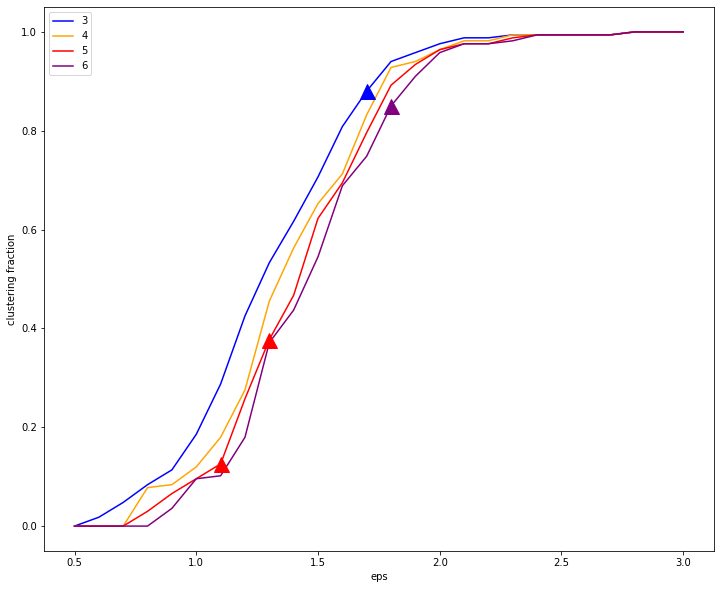

In [18]:
epsvec = np.arange(0.5,3.1,0.1)
min_samples_vec = np.arange(3,7,1)
cluster_count = np.zeros([len(min_samples_vec),len(epsvec)])
frac_outliers = cluster_count.copy()

for i in range(0,len(min_samples_vec)):
    for j in range(0,len(epsvec)):
        dbscan = DBSCAN(eps = epsvec[j], min_samples = min_samples_vec[i], metric = "euclidean")
        dbscan.fit(scaled_data[numerical_features])
        cluster_count[i,j] = len(np.unique(dbscan.labels_[dbscan.labels_ != -1]))
        frac_outliers[i,j] = len(dbscan.labels_[dbscan.labels_ == -1])/len(dbscan.labels_)

colorvec = ["blue", "orange", "red", "purple"]
fig, ax = plt.subplots(1, figsize = (12,10))
for i in range(0,len(min_samples_vec)):
    plt.plot(epsvec, cluster_count[i,:], color = colorvec[i])
    plt.plot(epsvec, cluster_count[i,:], '.', ms = 15, color = colorvec[i])
plt.plot(1.7, 3, '^', color = "blue", ms = 15) # min_samples = 3
plt.plot(1.3, 3, '^', color = "red", ms = 15) # min_samples = 5
plt.plot(1.8, 2, '^', color = "purple", ms = 15) # min_samples = 6
plt.plot(1.1, 2, '^', color = "red", ms = 15) # min_samples = 5
plt.xlabel("eps")
plt.ylabel("numer of clusters")
plt.show()

colorvec = ["blue", "orange", "red", "purple"]
fig, ax = plt.subplots(1, figsize = (12,10))
for i in range(0,len(min_samples_vec)):
    plt.plot(epsvec, 1 - frac_outliers[i,:], ms = 10, color = colorvec[i])
plt.plot(1.7, 1 - frac_outliers[0,12], '^', color = "blue", ms = 15) # min_samples = 3
plt.plot(1.3, 1 - frac_outliers[2,8], '^', color = "red", ms = 15) # min_samples = 5
plt.plot(1.8, 1 - frac_outliers[3,13], '^', color = "purple", ms = 15) # min_samples = 6
plt.plot(1.1, 1 - frac_outliers[2,6], '^', color = "red", ms = 15) # min_samples = 5
plt.xlabel("eps")
plt.ylabel("clustering fraction")
plt.legend(min_samples_vec)
plt.show()

Note that the triangles in the plot indicate points in parameter space we will examine. more closely below.

First, we note that the number of clusters is zero for small `eps` and one for large `eps`. This is the expected behavior of the DBSCAN algorithm. Small values of `eps` correspond to small clustering neighborhoods, and very small values tend to result in every point being classified as outliers. (We see that the clustering fraction also goes to zero for small `eps`.) On the other hand, the limit of very large `eps` leads to every point being classified in the same cluster. (The clustering fraction goes to one for large `eps`.)

There is one value of the parmeters (at least over the range examined here) that results in high clustering fraction and three clusters: `min_samples` $ = 3$ and `eps` $= 1.7$. Let's take a look at this model and a model with three clusters and a lower clustering fraction (`min_samples` $= 5$, `eps` $= 1.3$):

### Three-Cluster DBSCAN Results

eps = 1.7, min_samples = 3


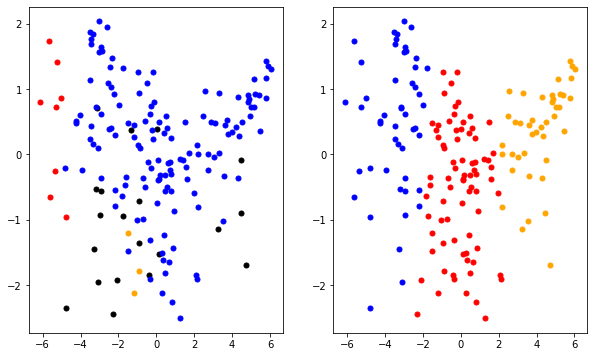

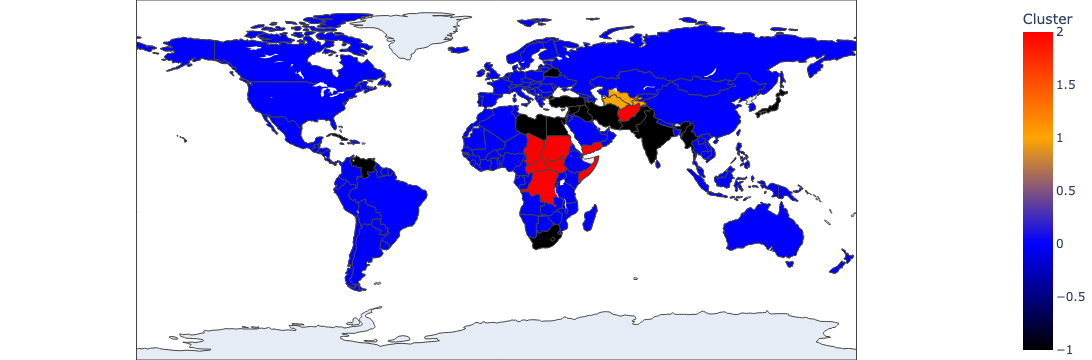

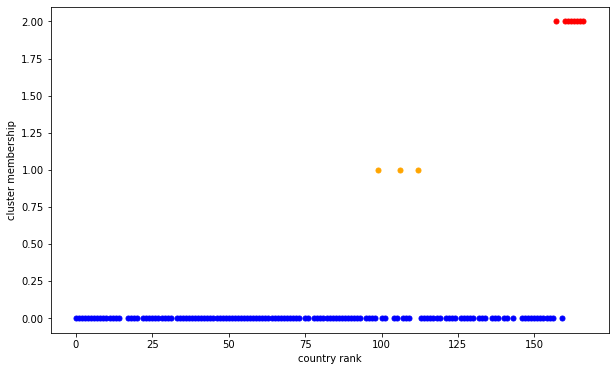

In [19]:
print("eps = 1.7, min_samples = 3")

dbscan = DBSCAN(eps = 1.7, min_samples = 3, metric = "euclidean").fit(scaled_data[numerical_features])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6))
ax1.plot(pca2_trans[dbscan.labels_ == -1, 0], pca2_trans[dbscan.labels_ == -1, 1], '.', color = "black", ms = 10)
ax1.plot(pca2_trans[dbscan.labels_ == 0, 0], pca2_trans[dbscan.labels_ == 0, 1], '.', color = "blue", ms = 10)
ax1.plot(pca2_trans[dbscan.labels_ == 1, 0], pca2_trans[dbscan.labels_ == 1, 1], '.', color = "orange", ms = 10)
ax1.plot(pca2_trans[dbscan.labels_ == 2, 0], pca2_trans[dbscan.labels_ == 2, 1], '.', color = "red", ms = 10)
ax2.plot(pca2_trans[km.labels_ == -1, 0], pca2_trans[km.labels_ == -1, 1], '.', color = "black", ms = 10)
ax2.plot(pca2_trans[km.labels_ == 0, 0], pca2_trans[km.labels_ == 0, 1], '.', color = "blue", ms = 10)
ax2.plot(pca2_trans[km.labels_ == 1, 0], pca2_trans[km.labels_ == 1, 1], '.', color = "orange", ms = 10)
ax2.plot(pca2_trans[km.labels_ == 2, 0], pca2_trans[km.labels_ == 2, 1], '.', color = "red", ms = 10)
plt.show()

cluster_df = pd.DataFrame({"Country": data["Country"].tolist(),
                           "Cluster": dbscan.labels_})

colorvec = ["rgb(0, 0, 0)", "rgb(0, 0, 255)", "rgb(255, 165, 0)", "rgb(255, 0, 0)"]

fig = px.choropleth(cluster_df, locationmode = "country names", locations = cluster_df["Country"],
                    scope = "world", color = cluster_df["Cluster"],
                    color_continuous_scale = colorvec,
                    range_color = (-1,2))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

fig, ax = plt.subplots(1, figsize = (10,6))
xvec = country_rank[dbscan.labels_ != -1]
yvec = dbscan.labels_[dbscan.labels_ != -1]
plt.plot(xvec[yvec == 0], yvec[yvec == 0], '.', ms = 10, color = "blue")
plt.plot(xvec[yvec == 1], yvec[yvec == 1], '.', ms = 10, color = "orange")
plt.plot(xvec[yvec == 2], yvec[yvec == 2], '.', ms = 10, color = "red")
plt.xlabel("country rank")
plt.ylabel("cluster membership")
plt.show()

eps = 1.3, min_samples = 5


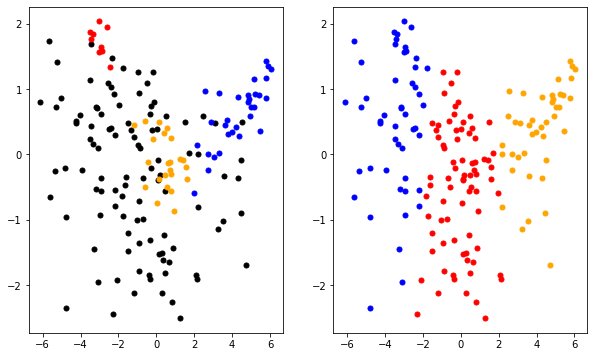

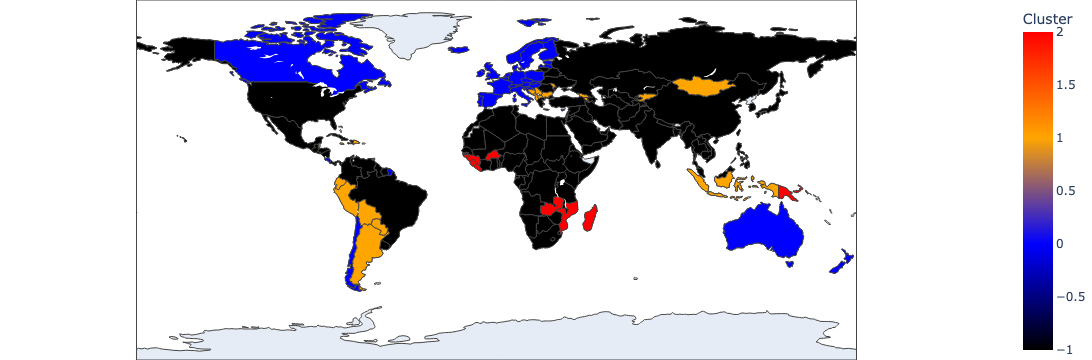

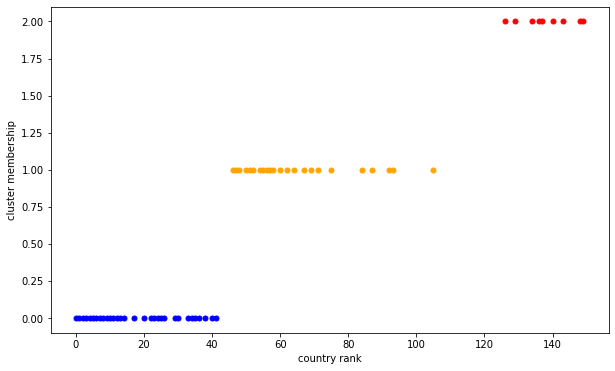

In [20]:
print("eps = 1.3, min_samples = 5")

dbscan = DBSCAN(eps = 1.3, min_samples = 5, metric = "euclidean").fit(scaled_data[numerical_features])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6))
ax1.plot(pca2_trans[dbscan.labels_ == -1, 0], pca2_trans[dbscan.labels_ == -1, 1], '.', color = "black", ms = 10)
ax1.plot(pca2_trans[dbscan.labels_ == 0, 0], pca2_trans[dbscan.labels_ == 0, 1], '.', color = "blue", ms = 10)
ax1.plot(pca2_trans[dbscan.labels_ == 1, 0], pca2_trans[dbscan.labels_ == 1, 1], '.', color = "orange", ms = 10)
ax1.plot(pca2_trans[dbscan.labels_ == 2, 0], pca2_trans[dbscan.labels_ == 2, 1], '.', color = "red", ms = 10)
ax2.plot(pca2_trans[km.labels_ == -1, 0], pca2_trans[km.labels_ == -1, 1], '.', color = "black", ms = 10)
ax2.plot(pca2_trans[km.labels_ == 0, 0], pca2_trans[km.labels_ == 0, 1], '.', color = "blue", ms = 10)
ax2.plot(pca2_trans[km.labels_ == 1, 0], pca2_trans[km.labels_ == 1, 1], '.', color = "orange", ms = 10)
ax2.plot(pca2_trans[km.labels_ == 2, 0], pca2_trans[km.labels_ == 2, 1], '.', color = "red", ms = 10)
plt.show()

cluster_df = pd.DataFrame({"Country": data["Country"].tolist(),
                           "Cluster": dbscan.labels_})

colorvec = ["rgb(0, 0, 0)", "rgb(0, 0, 255)", "rgb(255, 165, 0)", "rgb(255, 0, 0)"]

fig = px.choropleth(cluster_df, locationmode = "country names", locations = cluster_df["Country"],
                    scope = "world", color = cluster_df["Cluster"],
                    color_continuous_scale = colorvec,
                    range_color = (-1,2))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

fig, ax = plt.subplots(1, figsize = (10,6))
xvec = country_rank[dbscan.labels_ != -1]
yvec = dbscan.labels_[dbscan.labels_ != -1]
plt.plot(xvec[yvec == 0], yvec[yvec == 0], '.', ms = 10, color = "blue")
plt.plot(xvec[yvec == 1], yvec[yvec == 1], '.', ms = 10, color = "orange")
plt.plot(xvec[yvec == 2], yvec[yvec == 2], '.', ms = 10, color = "red")
plt.xlabel("country rank")
plt.ylabel("cluster membership")
plt.show()

We see that the high clustering fraction model clusters almost all of the countries, but the results are poorly correlated with country rank and most countries are in the same cluster. This makes the data difficult or impossible to interpret. On the other hand, the model with lower clustering fraction is well-sorted in country rank, but most countries are classified as outliers. Many parmaeter pairs resulting in three clusters were examined, but they all exhibited this essential trade-off.

Let's next look at a high cluster fraction model (`min_samples` $= 6$, `eps` $= 1.8$) and a low cluster fraction model (`min_samples` $= 5$, `eps` $= 1.1$) both resulting in two clusters:

### Two-Cluster DBSCAN Results

eps = 1.8, min_samples = 6


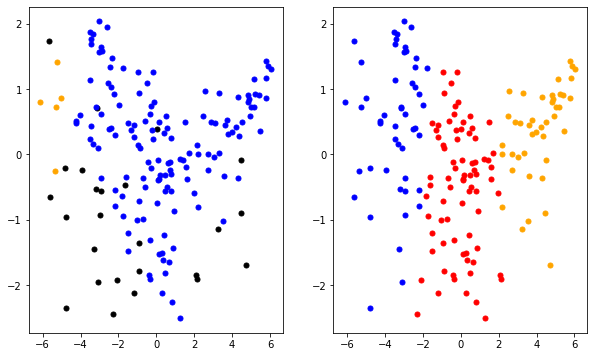

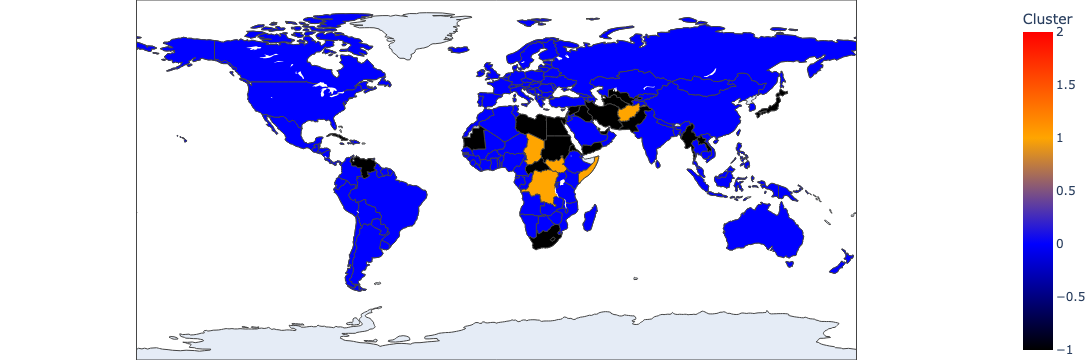

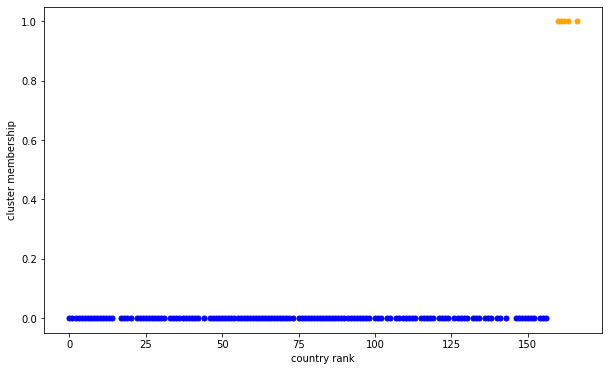

In [21]:
print("eps = 1.8, min_samples = 6")

dbscan = DBSCAN(eps = 1.8, min_samples = 6, metric = "euclidean").fit(scaled_data[numerical_features])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6))
ax1.plot(pca2_trans[dbscan.labels_ == -1, 0], pca2_trans[dbscan.labels_ == -1, 1], '.', color = "black", ms = 10)
ax1.plot(pca2_trans[dbscan.labels_ == 0, 0], pca2_trans[dbscan.labels_ == 0, 1], '.', color = "blue", ms = 10)
ax1.plot(pca2_trans[dbscan.labels_ == 1, 0], pca2_trans[dbscan.labels_ == 1, 1], '.', color = "orange", ms = 10)
ax1.plot(pca2_trans[dbscan.labels_ == 2, 0], pca2_trans[dbscan.labels_ == 2, 1], '.', color = "red", ms = 10)
ax2.plot(pca2_trans[km.labels_ == -1, 0], pca2_trans[km.labels_ == -1, 1], '.', color = "black", ms = 10)
ax2.plot(pca2_trans[km.labels_ == 0, 0], pca2_trans[km.labels_ == 0, 1], '.', color = "blue", ms = 10)
ax2.plot(pca2_trans[km.labels_ == 1, 0], pca2_trans[km.labels_ == 1, 1], '.', color = "orange", ms = 10)
ax2.plot(pca2_trans[km.labels_ == 2, 0], pca2_trans[km.labels_ == 2, 1], '.', color = "red", ms = 10)
plt.show()

cluster_df = pd.DataFrame({"Country": data["Country"].tolist(),
                           "Cluster": dbscan.labels_})

colorvec = ["rgb(0, 0, 0)", "rgb(0, 0, 255)", "rgb(255, 165, 0)", "rgb(255, 0, 0)"]

fig = px.choropleth(cluster_df, locationmode = "country names", locations = cluster_df["Country"],
                    scope = "world", color = cluster_df["Cluster"],
                    color_continuous_scale = colorvec,
                    range_color = (-1,2))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

fig, ax = plt.subplots(1, figsize = (10,6))
xvec = country_rank[dbscan.labels_ != -1]
yvec = dbscan.labels_[dbscan.labels_ != -1]
plt.plot(xvec[yvec == 0], yvec[yvec == 0], '.', ms = 10, color = "blue")
plt.plot(xvec[yvec == 1], yvec[yvec == 1], '.', ms = 10, color = "orange")
plt.xlabel("country rank")
plt.ylabel("cluster membership")
plt.show()

eps = 1.1, min_samples = 5


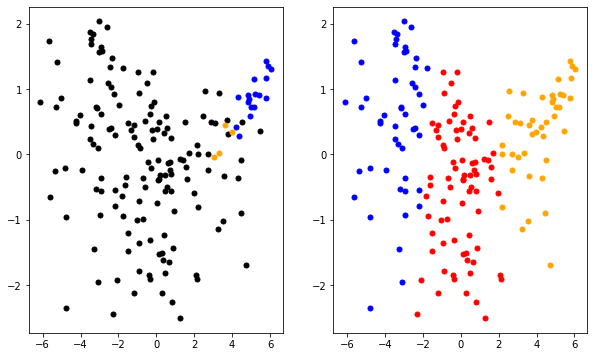

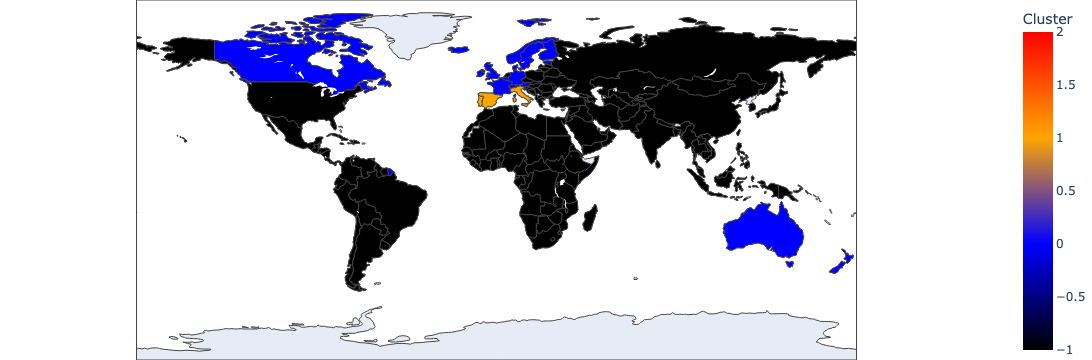

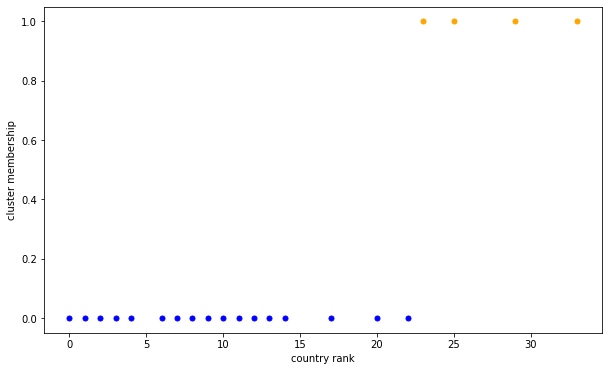

In [22]:
print("eps = 1.1, min_samples = 5")

dbscan = DBSCAN(eps = 1.1, min_samples = 5, metric = "euclidean").fit(scaled_data[numerical_features])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6))
ax1.plot(pca2_trans[dbscan.labels_ == -1, 0], pca2_trans[dbscan.labels_ == -1, 1], '.', color = "black", ms = 10)
ax1.plot(pca2_trans[dbscan.labels_ == 0, 0], pca2_trans[dbscan.labels_ == 0, 1], '.', color = "blue", ms = 10)
ax1.plot(pca2_trans[dbscan.labels_ == 1, 0], pca2_trans[dbscan.labels_ == 1, 1], '.', color = "orange", ms = 10)
ax1.plot(pca2_trans[dbscan.labels_ == 2, 0], pca2_trans[dbscan.labels_ == 2, 1], '.', color = "red", ms = 10)
ax2.plot(pca2_trans[km.labels_ == -1, 0], pca2_trans[km.labels_ == -1, 1], '.', color = "black", ms = 10)
ax2.plot(pca2_trans[km.labels_ == 0, 0], pca2_trans[km.labels_ == 0, 1], '.', color = "blue", ms = 10)
ax2.plot(pca2_trans[km.labels_ == 1, 0], pca2_trans[km.labels_ == 1, 1], '.', color = "orange", ms = 10)
ax2.plot(pca2_trans[km.labels_ == 2, 0], pca2_trans[km.labels_ == 2, 1], '.', color = "red", ms = 10)
plt.show()

cluster_df = pd.DataFrame({"Country": data["Country"].tolist(),
                           "Cluster": dbscan.labels_})

colorvec = ["rgb(0, 0, 0)", "rgb(0, 0, 255)", "rgb(255, 165, 0)", "rgb(255, 0, 0)"]

fig = px.choropleth(cluster_df, locationmode = "country names", locations = cluster_df["Country"],
                    scope = "world", color = cluster_df["Cluster"],
                    color_continuous_scale = colorvec,
                    range_color = (-1,2))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

fig, ax = plt.subplots(1, figsize = (10,6))
xvec = country_rank[dbscan.labels_ != -1]
yvec = dbscan.labels_[dbscan.labels_ != -1]
plt.plot(xvec[yvec == 0], yvec[yvec == 0], '.', ms = 10, color = "blue")
plt.plot(xvec[yvec == 1], yvec[yvec == 1], '.', ms = 10, color = "orange")
plt.xlabel("country rank")
plt.ylabel("cluster membership")
plt.show()

Both are well-sorted in country rank, but the high cluster fraction model classifies almost all countries in the same cluster, while the lower cluster fraction model does not place most countries in a cluster. Again, this discontinuous, qualitative transition is typical of two-cluster DBSCAN models.

## Key Findings

The key findings of the report are as follows:
* Both k-means and hierarchical agglomerative clustering (HAC) find a similar pattern of three clusters intrinsic to this data. This corroborates the robustness our clustering results.
* The clusters found with k-means and HAC recapitulate typically purported geographic patterns in development.
* Over the range of hyperparameters examined, the density-based DBSCAN method fails to find a region of parameter in space in which 1) a sufficient number of countries are clustered (rather than being classified as outliers), 2) the large majority of countries are not all placed in the same cluster, and 3) the clusters admit an interpretation in terms of country rank or geographic location.
* The preceding point likely indicates that density-based methods are not appropriate for this data.
* In addition to corroborating the three clusters identified using k-means, HAC also shows potentially interesting fine structure in the clustering, for example indicating that Europe can be further divided between the Nordic countries on one hand and Western and Eastern Europe on the other.


## Limitations and Future Work

This analysis is based on a single year's data. A more robust analysis would incorporate multiple years to examine how clustering changes over time and determine if there is any temporal robustness in clustering patterns.

Additionally, this data is taken from a single non-governmental source. A more robust analysis would incorporate data from other sources like the IMF and World Bank to examine the robustness of the clustering identified here.

The fact that this data reproduces the typical geographical clustering associated with development could indicate that this clustering is indeed robust. It could also indicate that this data possibly suffers from cultural, geographic, and economic biases. The results of this analysis could be made more robust by comparing them to the results obtained by analyzing data from other sources, including non-Western sources, for example.

The fine structure clustering identific in the HAC analysis is potentially interesting. Future work could focus on identifying sub-regions with different development "micro-levels" within larger agglomerates. This could, for example, lead to smaller scale, geographically localized policy developments with the aim of equalizing development within larger regions.